In [103]:
# Importing Necessary Libraries
import cv2
import os
import shutil 
import math
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# # Function for Formatting Dataset
# def FormatDataset(dataset_src, dataset_dest, classes):
#     # Making a Copy of Dataset
#     new_cropped_dest = [os.path.join(dataset_dest, cls, 'CROPPED') for cls in classes];
#     new_complete_dest = [os.path.join(dataset_dest, cls, 'COMPLETE') for cls in classes];
#     cropped_src = [ dataset_src + "/im_" + cls + "/im_" + cls + "/CROPPED" for cls in classes ];
#     complete_src = [ dataset_src + "/im_" + cls + "/im_" + cls for cls in classes ];
#     for (dest1, dest2) in zip(new_cropped_dest, new_complete_dest):
#         os.makedirs(dest1);
#         os.makedirs(dest2);
#     # Formating Cropped Images
#     for (src,new_dest) in zip(cropped_src, new_cropped_dest):
#         for file in os.listdir(src):
#             filename, file_ext = os.path.splitext(file);
#             if file_ext == '.bmp':
#                 img_des = os.path.join(new_dest, filename + '.jpg');
#                 img = cv2.imread(os.path.join(src, file));
#                 img = cv2.resize(img, (64, 64));
#                 img = cv2.copyMakeBorder(img, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value=0);
#                 img = cv2.blur(img, (2, 2));
#                 cv2.imwrite(img_des ,img);
#     # Formatting Complete Images
#     for (src,new_dest) in zip(complete_src, new_complete_dest):
#         for file in os.listdir(src):
#             filename, file_ext = os.path.splitext(file);
#             if file_ext == '.bmp':
#                 img_des = os.path.join(new_dest, filename + '.jpg');
#                 img = cv2.imread(os.path.join(src, file));
#                 img = cv2.resize(img, (256, 256));
#                 img = cv2.copyMakeBorder(img, 2, 2, 2, 2, cv2.BORDER_CONSTANT, value=0);
#                 img = cv2.blur(img, (2, 2));
#                 cv2.imwrite(img_des ,img);

# # Source Location for Dataset
# src = './Dataset';
# # Destination Location for Dataset
# dest = './CervicalCancer';
# # Image Classes
# classes = ["Dyskeratotic","Koilocytotic","Metaplastic","Parabasal","Superficial-Intermediate"];
# # Formatting Dataset
# FormatDataset(src, dest, classes);

In [ ]:
# root_dir = "./CervicalCancer"
# classes = ["Dyskeratotic","Koilocytotic","Metaplastic","Parabasal","Superficial-Intermediate"]

# def GetDatasetSize(path, classes, main = "CROPPED"):
#     num_of_image = {}
#     for cls in classes:
#         # Counting the Number of Files in the Folder
#         num_of_image[cls] = len(os.listdir(os.path.join(path, cls, main)));
#     return num_of_image;

# print(GetDatasetSize(root_dir, classes, "COMPLETE"));

### Split the Dataset such that we have
* 70% for Train Data
* 15% for Validation Data
* 15% for Testing Data

In [ ]:
# Function for Creating Train / Validation / Test folders (One time use Only)

def TrainValTestSplit(root_dir, classes_dir, main = "CROPPED", val_ratio = 0.15, test_ratio = 0.15):
    for cls in classes_dir:
        # Creating Split Folders
        os.makedirs('train/' + cls)
        os.makedirs('val/' + cls)
        os.makedirs('test/' + cls)

        # Folder to copy images from
        src = os.path.join(root_dir, cls, main);

        # Spliting the Files in the Given ratio
        allFileNames = os.listdir(src)
        np.random.shuffle(allFileNames)
        train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames)* (1 - (val_ratio + test_ratio))), int(len(allFileNames)* (1 - test_ratio))])

        train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
        val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
        test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

        # Printing the Split Details
        print(cls,':')
        print('Total images: ', len(allFileNames))
        print('Training: ', len(train_FileNames))
        print('Validation: ', len(val_FileNames))
        print('Testing: ', len(test_FileNames))

        # Copy-pasting images
        for name in train_FileNames:
            shutil.copy(name, 'train/' + cls)

        for name in val_FileNames:
            shutil.copy(name, 'val/' + cls)

        for name in test_FileNames:
            shutil.copy(name, 'test/' + cls)
        print();
        

# Preforming Train / Validation / Test Split
root_dir = "./CervicalCancer"               # Dataset Root Folder
classes_dir = ["Dyskeratotic", "Koilocytotic", "Metaplastic", "Parabasal", "Superficial-Intermediate"]   # Classes
TrainValTestSplit(root_dir, classes_dir);

### Model Imports


In [104]:
import tensorflow as tf;
from tensorflow.keras.preprocessing import image



### Preparing data using data generator 

In [148]:
# Expand the size of dataset with new transformed images from the original dataset using ImageDataGenerator.
train_datagen = image.ImageDataGenerator(zoom_range = 0.2, shear_range = 0.2 , rescale = 1./255 , horizontal_flip=True)
val_datagen = image.ImageDataGenerator(rescale = 1./255)
test_datagen = image.ImageDataGenerator(rescale = 1./255)

In [149]:
train_data = train_datagen.flow_from_directory(directory= "./train", target_size=(64, 64), batch_size=32, class_mode = 'categorical', shuffle=True)

Found 2832 images belonging to 5 classes.


In [150]:
val_data = val_datagen.flow_from_directory(directory= "./val", target_size=(64, 64), batch_size=32, class_mode = 'categorical',shuffle=True)

Found 608 images belonging to 5 classes.


In [185]:
test_data = test_datagen.flow_from_directory(directory= "./test", target_size=(64, 64), batch_size=32, class_mode = 'categorical',shuffle=False)

Found 609 images belonging to 5 classes.


In [152]:
train_data.class_indices

{'Dyskeratotic': 0,
 'Koilocytotic': 1,
 'Metaplastic': 2,
 'Parabasal': 3,
 'Superficial-Intermediate': 4}

In [153]:
#Callback
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)

# Classic CNN


In [154]:
from keras.layers import Dense,Conv2D, Flatten, MaxPool2D, Dropout
from keras.models import Sequential
from tensorflow.keras.preprocessing import image
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.optimizers import Adam

In [155]:
# Adding Model check point Callback
mc_cnn = ModelCheckpoint(filepath="cnn.hdf5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto');
call_back_cnn = [ mc_cnn,es ];

In [156]:
# CNN Model 

model_cnn = Sequential() 
# Convolutional Layer with input shape (64,64,3)
model_cnn.add(Conv2D(filters=16, kernel_size= (3,3), activation= 'relu', input_shape=(64,64,3)) )

model_cnn.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu' ))
model_cnn.add(MaxPool2D(pool_size=(2,2)))


model_cnn.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu' ))
model_cnn.add(MaxPool2D(pool_size=(2,2)))


model_cnn.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu' ))
model_cnn.add(MaxPool2D(pool_size=(2,2)))

model_cnn.add(Dropout(rate=0.25))

model_cnn.add(Flatten())
model_cnn.add(Dense(units=64, activation='relu'))
model_cnn.add(Dropout(rate=0.25))
model_cnn.add(Dense(units=5, activation='sigmoid'))

model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']  )
 
model_cnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 62, 62, 16)        448       
                                                                 
 conv2d_36 (Conv2D)          (None, 60, 60, 32)        4640      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 30, 30, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 12, 12, 128)      

In [157]:
# Fitting the Model
cnn = model_cnn.fit(train_data, 
                    epochs= 150,
                    validation_data= val_data, 
                    validation_steps= 6,
                    callbacks = call_back_cnn,
                    shuffle=True)

Epoch 1/150


2023-03-29 12:43:57.380975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


89/89 [==============================] - ETA: 0s - loss: 1.1920 - accuracy: 0.5000

2023-03-29 12:44:01.960234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.57812, saving model to cnn.hdf5
89/89 [==============================] - 5s 48ms/step - loss: 1.1920 - accuracy: 0.5000 - val_loss: 1.0772 - val_accuracy: 0.5781
Epoch 2/150
88/89 [============================>.] - ETA: 0s - loss: 0.9735 - accuracy: 0.6471
Epoch 2: val_accuracy improved from 0.57812 to 0.72396, saving model to cnn.hdf5
89/89 [==============================] - 3s 30ms/step - loss: 0.9746 - accuracy: 0.6472 - val_loss: 0.7544 - val_accuracy: 0.7240
Epoch 3/150
88/89 [============================>.] - ETA: 0s - loss: 0.8186 - accuracy: 0.7011
Epoch 3: val_accuracy did not improve from 0.72396
89/89 [==============================] - 3s 31ms/step - loss: 0.8177 - accuracy: 0.7013 - val_loss: 0.7124 - val_accuracy: 0.7031
Epoch 4/150
88/89 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.7600
Epoch 4: val_accuracy did not improve from 0.72396
89/89 [==============================] - 3s 29ms/step - loss: 0

In [191]:
# Checking the Accuracy of the Model 
accuracy_cnn = model_cnn.evaluate_generator(generator= test_data)[1] 
print(f"The accuracy of your model is = {accuracy_cnn*100} %")

The accuracy of your model is = 90.8046007156372 %


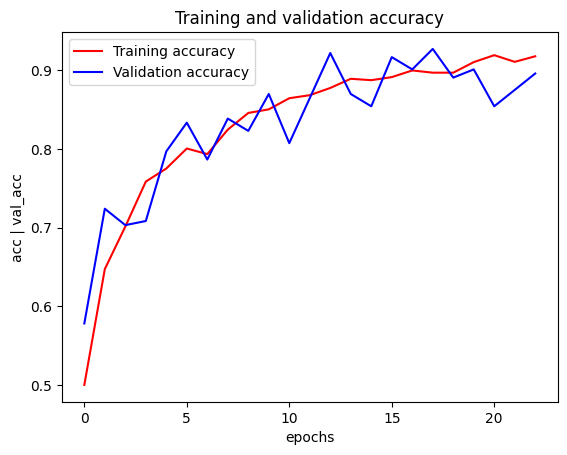

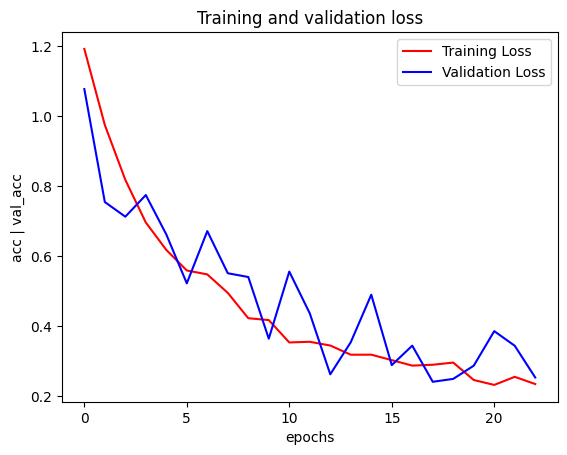

In [159]:
import matplotlib.pyplot as plt
acc = cnn.history['accuracy']
val_acc = cnn.history['val_accuracy']
loss = cnn.history['loss']
val_loss = cnn.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.xlabel("epochs")
plt.ylabel("acc | val_acc")
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.xlabel("epochs")
plt.ylabel("acc | val_acc")
plt.title('Training and validation loss')
plt.legend()

plt.show()

# AlexNet


In [117]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
# metric
# from keras.metrics import binary_crossentropy
# optimization method (Stochastic Gradient Descent (SGD))
# from keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam


In [118]:

model_alexnet = Sequential()

    # Layer 1
model_alexnet.add(Conv2D(96, kernel_size=(11, 11), strides=4, padding='valid', activation='relu', input_shape=(64,64,3)))
model_alexnet.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    # Layer 2
model_alexnet.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model_alexnet.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    # Layers 3-5
model_alexnet.add(Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'))
model_alexnet.add(Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'))
model_alexnet.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model_alexnet.add(MaxPooling2D(pool_size=(3, 3), strides=2))

    # Layers 6-8
model_alexnet.add(Flatten())
model_alexnet.add(Dense(4096, activation='relu'))
model_alexnet.add(Dropout(0.5))
model_alexnet.add(Dense(4096, activation='relu'))
model_alexnet.add(Dropout(0.5))
model_alexnet.add(Dense(5, activation='softmax'))

    # Compile the model
optimizer = Adam(lr=0.0001)
model_alexnet.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model_alexnet.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 14, 14, 96)        34944     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 7, 7, 96)         0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 7, 7, 256)         221440    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 3, 3, 256)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 3, 3, 384)         885120    
                                                                 
 conv2d_15 (Conv2D)          (None, 3, 3, 384)        

In [120]:
mc_alex = ModelCheckpoint(filepath="alexnet.hdf5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto');
call_back_alex = [ mc_alex , es];

In [121]:
history_alexnet = model_alexnet.fit(train_data, 
                  epochs= 150,
                  validation_data= val_data, 
                  callbacks = call_back_alex )

Epoch 1/150


2023-03-29 12:34:12.769792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - ETA: 0s - loss: 1.4607 - accuracy: 0.2931

2023-03-29 12:34:15.957339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.46546, saving model to alexnet.hdf5
29/29 [==============================] - 5s 110ms/step - loss: 1.4607 - accuracy: 0.2931 - val_loss: 1.1634 - val_accuracy: 0.4655
Epoch 2/150
29/29 [==============================] - ETA: 0s - loss: 1.2183 - accuracy: 0.4721
Epoch 2: val_accuracy improved from 0.46546 to 0.54770, saving model to alexnet.hdf5
29/29 [==============================] - 3s 91ms/step - loss: 1.2183 - accuracy: 0.4721 - val_loss: 1.1817 - val_accuracy: 0.5477
Epoch 3/150
29/29 [==============================] - ETA: 0s - loss: 1.0982 - accuracy: 0.5420
Epoch 3: val_accuracy improved from 0.54770 to 0.60197, saving model to alexnet.hdf5
29/29 [==============================] - 3s 87ms/step - loss: 1.0982 - accuracy: 0.5420 - val_loss: 1.0240 - val_accuracy: 0.6020
Epoch 4/150
29/29 [==============================] - ETA: 0s - loss: 0.9942 - accuracy: 0.6130
Epoch 4: val_accuracy improved from 0.60197 to 0.66118, saving model to

In [192]:
# Checking the Accuracy of the Model 
accuracy_alex = model_alexnet.evaluate_generator(generator= test_data)[1] 
print(f"The accuracy of your model is = {accuracy_alex*100} %")

The accuracy of your model is = 91.95402264595032 %


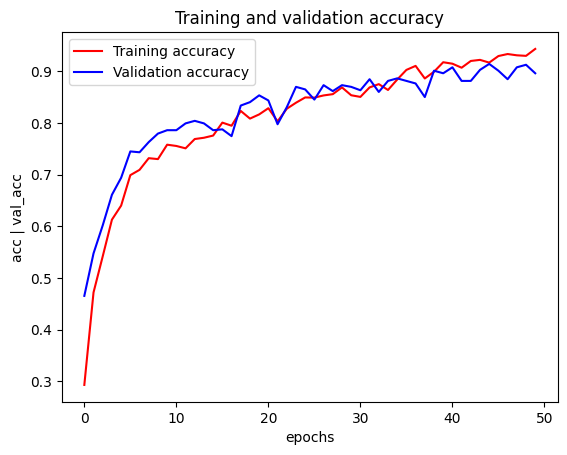

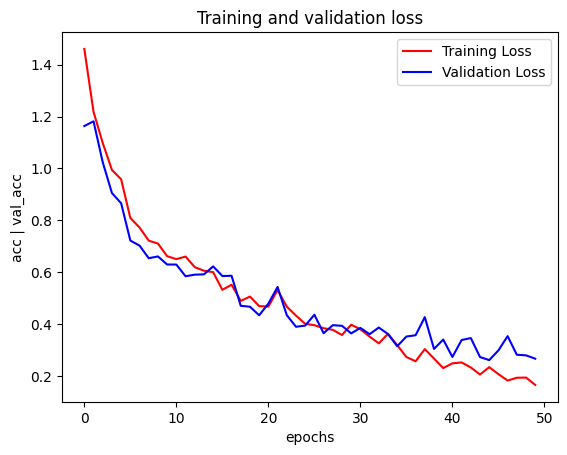

In [123]:
import matplotlib.pyplot as plt
acc = history_alexnet.history['accuracy']
val_acc = history_alexnet.history['val_accuracy']
loss = history_alexnet.history['loss']
val_loss = history_alexnet.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.xlabel("epochs")
plt.ylabel("acc | val_acc")
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.xlabel("epochs")
plt.ylabel("acc | val_acc")
plt.title('Training and validation loss')
plt.legend()

plt.show()

# SqueezeNet

In [124]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Dropout, GlobalAveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model

# Define input tensor
input_tensor = Input(shape=(64, 64, 3))

# SqueezeNet layers
x = Conv2D(96, kernel_size=7, strides=2, activation='relu', padding='same')(input_tensor)
x = MaxPooling2D(pool_size=3, strides=2)(x)

# Fire modules
x = concatenate([Conv2D(filters=16, kernel_size=1, activation='relu', padding='same')(x), Conv2D(filters=64, kernel_size=1, activation='relu', padding='same')(x)])
x = concatenate([Conv2D(filters=16, kernel_size=1, activation='relu', padding='same')(x), Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)])
x = MaxPooling2D(pool_size=3, strides=2)(x)

x = concatenate([Conv2D(filters=32, kernel_size=1, activation='relu', padding='same')(x), Conv2D(filters=128, kernel_size=1, activation='relu', padding='same')(x)])
x = concatenate([Conv2D(filters=32, kernel_size=1, activation='relu', padding='same')(x), Conv2D(filters=128, kernel_size=3, activation='relu', padding='same')(x)])
x = MaxPooling2D(pool_size=3, strides=2)(x)

x = concatenate([Conv2D(filters=48, kernel_size=1, activation='relu', padding='same')(x), Conv2D(filters=192, kernel_size=1, activation='relu', padding='same')(x)])
x = concatenate([Conv2D(filters=48, kernel_size=1, activation='relu', padding='same')(x), Conv2D(filters=192, kernel_size=3, activation='relu', padding='same')(x)])
x = concatenate([Conv2D(filters=64, kernel_size=1, activation='relu', padding='same')(x), Conv2D(filters=256, kernel_size=1, activation='relu', padding='same')(x)])
x = concatenate([Conv2D(filters=64, kernel_size=1, activation='relu', padding='same')(x), Conv2D(filters=256, kernel_size=3, activation='relu', padding='same')(x)])

# Output layers
x = Dropout(0.5)(x)
x = Conv2D(filters=5, kernel_size=1, activation='relu', padding='same')(x)
x = GlobalAveragePooling2D()(x)
output_tensor = Dense(5, activation='softmax')(x)

# Create model
model_squeezenet = Model(inputs=input_tensor, outputs=output_tensor)

# Compile model
model_squeezenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model_squeezenet.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_17 (Conv2D)             (None, 32, 32, 96)   14208       ['input_3[0][0]']                
                                                                                                  
 max_pooling2d_12 (MaxPooling2D  (None, 15, 15, 96)  0           ['conv2d_17[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_18 (Conv2D)             (None, 15, 15, 16)   1552        ['max_pooling2d_12[0][0]']   

In [125]:
mc_sqnet = ModelCheckpoint(filepath="squeezenet_net.hdf5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto');
call_back_sqnet = [ mc_sqnet ];

In [126]:
history_sqnet = model_squeezenet.fit(train_data, 
                  epochs= 64,
                  validation_data= val_data, 
                  validation_steps= 6,
                  callbacks = call_back_sqnet )

Epoch 1/64


2023-03-29 12:36:15.690507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - ETA: 0s - loss: 1.6053 - accuracy: 0.2094

2023-03-29 12:36:20.364421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.22833, saving model to squeezenet_net.hdf5
29/29 [==============================] - 6s 147ms/step - loss: 1.6053 - accuracy: 0.2094 - val_loss: 1.5867 - val_accuracy: 0.2283
Epoch 2/64
29/29 [==============================] - ETA: 0s - loss: 1.5577 - accuracy: 0.2200
Epoch 2: val_accuracy did not improve from 0.22833
29/29 [==============================] - 2s 70ms/step - loss: 1.5577 - accuracy: 0.2200 - val_loss: 1.4800 - val_accuracy: 0.1983
Epoch 3/64
29/29 [==============================] - ETA: 0s - loss: 1.3654 - accuracy: 0.3831
Epoch 3: val_accuracy improved from 0.22833 to 0.50500, saving model to squeezenet_net.hdf5
29/29 [==============================] - 2s 70ms/step - loss: 1.3654 - accuracy: 0.3831 - val_loss: 1.3534 - val_accuracy: 0.5050
Epoch 4/64
29/29 [==============================] - ETA: 0s - loss: 1.3355 - accuracy: 0.4220
Epoch 4: val_accuracy did not improve from 0.50500
29/29 [==============================] - 2s

In [193]:
accuracy_sqnet = model_squeezenet.evaluate_generator(generator= test_data)[1] 
print(f"The accuracy of your model is = {accuracy_sqnet*100} %")

The accuracy of your model is = 89.98358249664307 %


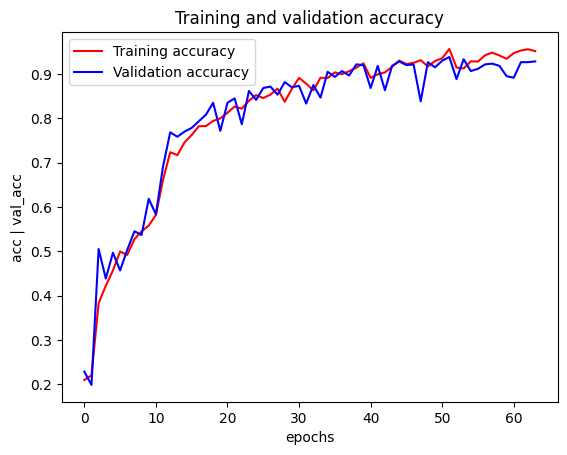

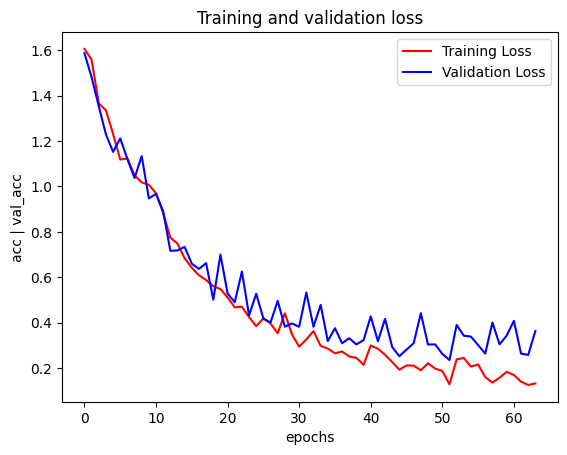

In [128]:
import matplotlib.pyplot as plt
acc = history_sqnet.history['accuracy']
val_acc = history_sqnet.history['val_accuracy']
loss = history_sqnet.history['loss']
val_loss = history_sqnet.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.xlabel("epochs")
plt.ylabel("acc | val_acc")
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.xlabel("epochs")
plt.ylabel("acc | val_acc")
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Ensemble 

In [129]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input,Average
model_1 = load_model('./alexnet.hdf5')
model_1 = Model(inputs=model_1.inputs,
                outputs=model_1.outputs,
                name='name_of_model_1')
model_2 = load_model('./squeezenet_net.hdf5')
model_2 = Model(inputs=model_2.inputs,
                outputs=model_2.outputs,
                name='name_of_model_2')
model_3 = load_model('./cnn.hdf5')
model_3 = Model(inputs=model_3.inputs,
                outputs=model_3.outputs,
                name='name_of_model_3')

models = [model_1,model_2,model_3]
model_input = Input(shape=(64, 64, 3))
model_outputs = [model(model_input) for model in models]
# print(model_outputs)
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

In [130]:
ensemble_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [132]:
mc4 = ModelCheckpoint(filepath="Ensemble.h5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto');
call_back_ens = [ mc4 ,es ];

In [133]:
history=ensemble_model.fit(
  train_data,
  validation_data=val_data,
  epochs=150,
  callbacks=call_back_ens,
  validation_steps=6
  )

Epoch 1/150


2023-03-29 12:39:01.910897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - ETA: 0s - loss: 0.5880 - accuracy: 0.8937

2023-03-29 12:39:10.959997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.90000, saving model to Ensemble.h5
29/29 [==============================] - 11s 273ms/step - loss: 0.5880 - accuracy: 0.8937 - val_loss: 0.6759 - val_accuracy: 0.9000
Epoch 2/150
29/29 [==============================] - ETA: 0s - loss: 0.5231 - accuracy: 0.9153
Epoch 2: val_accuracy did not improve from 0.90000
29/29 [==============================] - 3s 96ms/step - loss: 0.5231 - accuracy: 0.9153 - val_loss: 0.6315 - val_accuracy: 0.8750
Epoch 3/150
29/29 [==============================] - ETA: 0s - loss: 0.5057 - accuracy: 0.9198
Epoch 3: val_accuracy did not improve from 0.90000
29/29 [==============================] - 3s 98ms/step - loss: 0.5057 - accuracy: 0.9198 - val_loss: 0.6018 - val_accuracy: 0.8983
Epoch 4/150
29/29 [==============================] - ETA: 0s - loss: 0.4873 - accuracy: 0.9326
Epoch 4: val_accuracy improved from 0.90000 to 0.91000, saving model to Ensemble.h5
29/29 [==============================] - 3s 100ms/step 

In [194]:
accuracy_ensemble = ensemble_model.evaluate_generator(generator= test_data)[1] 
print(f"The accuracy of your model is = {accuracy_ensemble*100} %")

The accuracy of your model is = 90.47619104385376 %


In [135]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [136]:
epochs = range(len(acc))


<Figure size 640x480 with 0 Axes>

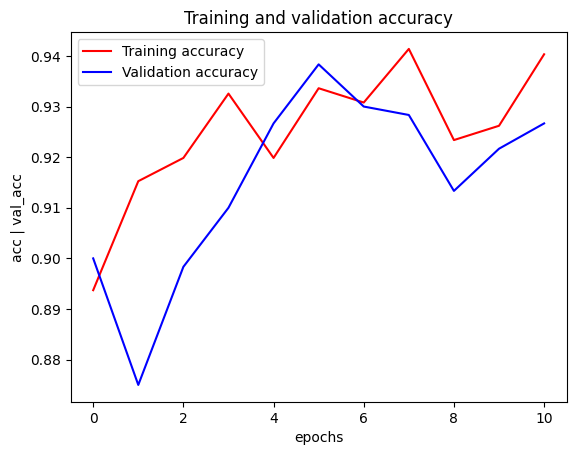

<Figure size 640x480 with 0 Axes>

In [137]:
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.xlabel("epochs")
plt.ylabel("acc | val_acc")
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()


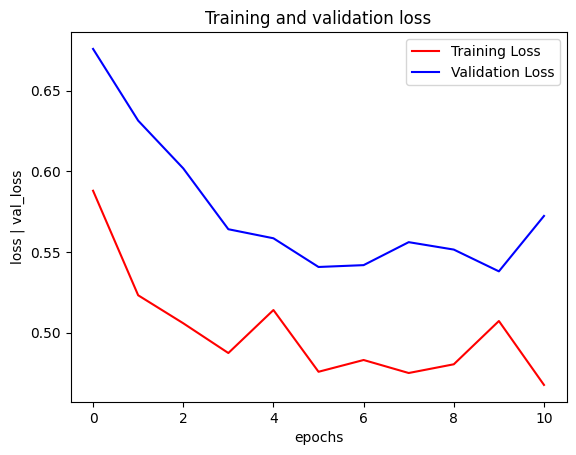

In [138]:
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.xlabel("epochs")
plt.ylabel("loss | val_loss")
plt.title('Training and validation loss')
plt.legend()

In [139]:
plt.show()

2023-03-29 12:39:58.569888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/7 [===>..........................] - ETA: 1s

2023-03-29 12:40:00.464854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 37ms/step


2023-03-29 12:40:00.952434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/7 [===>..........................] - ETA: 1s

2023-03-29 12:40:02.024515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 29ms/step


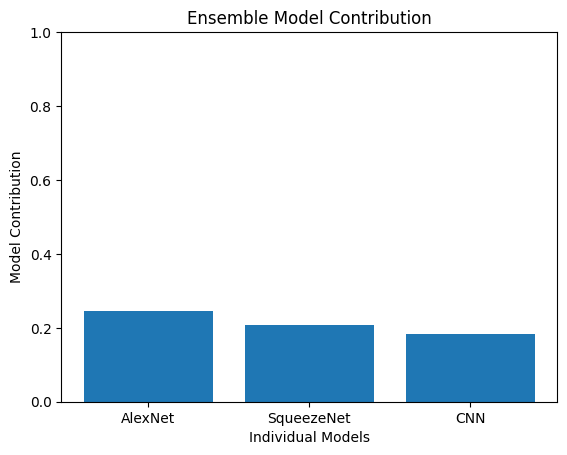

In [140]:
import numpy as np
import matplotlib.pyplot as plt



# Step 1: Load the test dataset
num_classes = 5
test_images = test_data
test_labels = ["Dyskeratotic","Koilocytotic","Metaplastic","Parabasal","Superficial-Intermediate"]

# Step 2: Load the ensemble model
# ensemble_model = ensemble_model

# Step 3: Generate predictions
ensemble_preds = ensemble_model.predict(test_images)
ensemble_pred_labels = np.argmax(ensemble_preds, axis=1)


# Step 4: Compute the contribution of each model
model_contributions = []
for layer in ensemble_model.layers:
    if isinstance(layer, tf.keras.Model):
        model = layer
        model_preds = model.predict(test_images)
        model_pred_labels = np.argmax(model_preds, axis=1)
        model_contributions.append(np.mean(model_pred_labels == ensemble_pred_labels))




# print(model_contributions)
# Step 5: Visualize the model contribution
fig, ax = plt.subplots()
ax.bar(np.arange(len(model_contributions)), model_contributions, align='center')
ax.set_xticks(np.arange(len(model_contributions)))
ax.set_xticklabels(['AlexNet', 'SqueezeNet', 'CNN'])
ax.set_ylim([0, 1])
ax.set_xlabel('Individual Models')
ax.set_ylabel('Model Contribution')
ax.set_title('Ensemble Model Contribution')
plt.show()


# Classification Report (Ensemble)

In [188]:
import numpy as np
from sklearn.metrics import classification_report

# model_4 = load_model('./Ensemble.h5')

# Get the ensemble model predictions
ensemble_pred_labels = np.argmax(ensemble_model.predict(test_data),axis=-1)

# Print the classification report
class_names = ["Dyskeratotic","Koilocytotic","Metaplastic","Parabasal","Superficial-Intermediate"]
print(classification_report(test_data.classes, ensemble_pred_labels, target_names=class_names))


20/20 [==============================] - 1s 51ms/step
                          precision    recall  f1-score   support

            Dyskeratotic       0.79      0.97      0.87       122
            Koilocytotic       0.89      0.79      0.84       124
             Metaplastic       0.93      0.87      0.90       119
               Parabasal       0.97      0.97      0.97       119
Superficial-Intermediate       0.97      0.92      0.95       125

                accuracy                           0.90       609
               macro avg       0.91      0.91      0.91       609
            weighted avg       0.91      0.90      0.90       609



# Confusion Matrix 

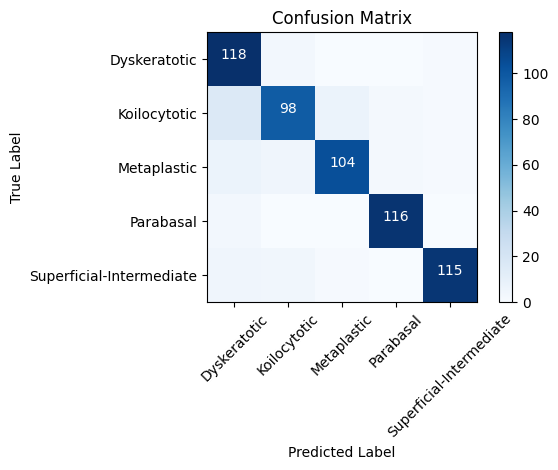

In [189]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Sample true and predicted labels
true_labels = test_data.classes
predicted_labels = ensemble_pred_labels

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Define class labels
class_labels = class_names

# Plot confusion matrix
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add labels to each cell
thresh = conf_matrix.max() / 2
for i, j in zip(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


# Model wise accuracy 

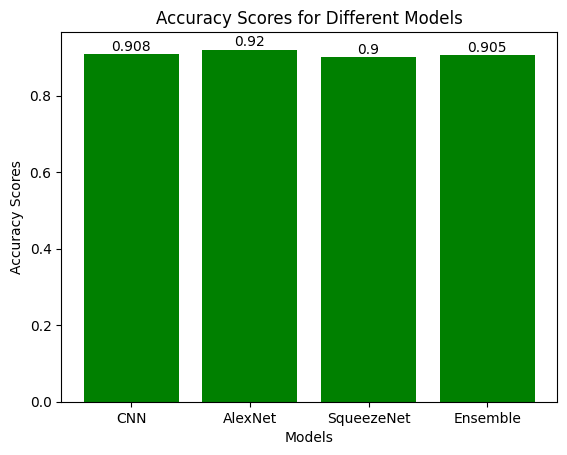

In [200]:
import matplotlib.pyplot as plt

# Sample data for accuracy scores
models = ['CNN', 'AlexNet', 'SqueezeNet', 'Ensemble']
accuracy_scores = [accuracy_cnn, accuracy_alex, accuracy_sqnet, accuracy_ensemble]
accuracy_scores_rounded = [round(score, 3) for score in accuracy_scores]


# Plot bar chart
fig, ax = plt.subplots()
ax.bar(models, accuracy_scores_rounded, color='green')
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy Scores')
ax.set_title('Accuracy Scores for Different Models')

# Add values to bars
for i, v in enumerate(accuracy_scores_rounded):
    ax.text(i, v+0.01, str(v), color='black', ha='center')

plt.show()


# Class Prediction for a single image


In [178]:
def cancerPrediction(path):
    classes_dir = ["Dyskeratotic","Koilocytotic","Metaplastic","Parabasal","Superficial-Intermediate"]
    # Loading Image
    img = image.load_img(path, target_size=(64,64))
    # Normalizing Image
    norm_img = image.img_to_array(img)/255
    # Converting Image to Numpy Array
    input_arr_img = np.array([norm_img])
    # Getting Predictions

    # modek - AlexNet
    pred = np.argmax(ensemble_model.predict(input_arr_img))

    # model - SqueezeNet
    # pred = np.argmax(model_squeezenet.predict(input_arr_img))

    # model - CNN
    # pred = np.argmax(model_cnn.predict(input_arr_img))

    # Printing Model Prediction
    print(classes_dir[pred])

path = "./Dataset/im_Parabasal/im_Parabasal/CROPPED/001_01.bmp"
# path = "./Dataset/im_Dyskeratotic/im_Dyskeratotic/CROPPED/001_04.bmp"
# path = "./Dataset/im_Koilocytotic/im_Koilocytotic/CROPPED/003_01.bmp"
# path = "./Dataset/im_Metaplastic/im_Metaplastic/CROPPED/001_01.bmp"
# path = "./Dataset/im_Superficial-Intermediate/im_Superficial-Intermediate/CROPPED/002_03.bmp"
cancerPrediction(path)

1/1 [==============================] - 0s 162ms/step
Parabasal
